# Word2Vec (Skipgram)

In [90]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt

In [46]:
np.__version__, torch.__version__, matplotlib.__version__

('1.25.2', '2.1.0', '3.7.2')

## 1. Load data

In [47]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
          "dog cat animal", "cat animal dog", "cat dog animal"]

# note : embedding of banana should be the same as embedding of apple and fruit, ws = 1

### 1.1 tokenization

In [48]:
# 1. tokenization
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

### 1.2 numericalization

In [49]:
# 2. numericalization
# find the unique words
flatten = lambda l:[item for sublist in l for item in sublist]

# assign unique integer
vocabs = list(set(flatten(corpus))) # all the words we have in the system ; <UNK>: for unknown words

In [50]:
vocabs

['dog', 'apple', 'animal', 'cat', 'fruit', 'banana']

In [51]:
# create handy mapping betweem integer and word
word2index = {v:idx for idx,v in enumerate(vocabs)} # a dictionary array

In [52]:
print(word2index)
print(word2index['dog'])
print(word2index['apple'])

{'dog': 0, 'apple': 1, 'animal': 2, 'cat': 3, 'fruit': 4, 'banana': 5}
0
1


In [53]:
# add <UNK>
vocabs.append("<UNK>")
word2index['<UNK>'] = 6

In [54]:
word2index

{'dog': 0,
 'apple': 1,
 'animal': 2,
 'cat': 3,
 'fruit': 4,
 'banana': 5,
 '<UNK>': 6}

In [55]:
# index to word
index2word = {v:k for k,v in word2index.items()}

In [56]:
index2word

{0: 'dog',
 1: 'apple',
 2: 'animal',
 3: 'cat',
 4: 'fruit',
 5: 'banana',
 6: '<UNK>'}

## 2. Prepare train data

In [57]:
# create pairs of center word and outside word

def random_batch(batch_size, corpus):
    
    skipgrams = []

    # loop each corpus
    for doc in corpus:
        
        # look from the 2nd word until second last word
        for i in range (1, len(doc)-1):
            
            # assign center word
            center = word2index[doc[i]]
                
            # assign outside word = 2 words (if ws = 2, we must assign 2 outside word for each center word )
            outside = (word2index[doc[i-1]], word2index[doc[i+1]])
            
            # for each of these two outside words, we gonna append to a list
            for each_out in outside:
                
                #center, outside1; cener, outside2;
                skipgrams.append([center,each_out])
                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace = False)
    
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]]) # center word
        labels.append([skipgrams[index][1]]) # outside word
    
    return np.array(inputs), np.array(labels)
            

In [58]:
x,y = random_batch (2, corpus)

In [59]:
x.shape # batch_size, 1 >> input to nn

(2, 1)

In [60]:
x

array([[0],
       [2]])

In [61]:
y.shape # batch_size,1 >> input to nn

(2, 1)

In [62]:
y

array([[2],
       [0]])

## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}} \log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c) = \frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

#### What is embedding?

In [67]:
vs = len(vocabs)

In [68]:
embedding = nn.Embedding(7, 2)

In [70]:
a = torch.LongTensor([3])
embedding(a)

# if we enter 3, embedding can return a vector for 3
    # Note: as we mention (7,2) 
    # vector dim: 2
    # range     : (0-7) // each number represent for each word

tensor([[-1.4666,  1.4091]], grad_fn=<EmbeddingBackward0>)

In [72]:
x_tensor = torch.LongTensor(x)
embedding(x_tensor)

tensor([[[ 1.5075,  1.8527]],

        [[-1.4666,  1.4091]]], grad_fn=<EmbeddingBackward0>)

In [73]:
embedding(x_tensor).shape # batch_size, 1, embedding_size

torch.Size([2, 1, 2])

#### Model

In [74]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center, outside, all_vocabs):
        center_embedding     = self.embedding_center(center)     # (batch_size, 1, embedding_size)
        outside_embedding    = self.embedding_center(outside)    # (batch_size, 1, embedding_size)
        all_vocabs_embedding = self.embedding_center(all_vocabs) # (batch_size, vocab_size, embedding_size)
        
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1,2)).squeeze(2))
        # (batch_size, 1,1) = (batch_size , 1, emb_size) @ (batch_size, emb_size, 1)
        # squeeze (batch_size, 1, 1) to (batch_size,1); use squeeze(dimension to squeeze)
        # (batch_size,1) = (batch_size , 1, emb_size) @ (batch_size, emb_size, 1)
        
        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1,2)).squeeze(2)
        # (batch_size, voc_size, 1)= (batch_size , voc_size, emb_size) @ (batch_size, emb_size, 1)
        # (batch_size, voc_size)   = (batch_size , voc_size, emb_size) @ (batch_size, emb_size, 1)
        
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) # (batch_size, 1)
        # 1 means sum across vocab_size >> (batch_size, voc_size) = (0,1)
        
        loss = -torch.mean(torch.log(top_term / lower_term_sum)) # scaler
        # loss needs to be only one number, we have (batch_size,1), so we take average in order to get only one number.
        
        return loss
    
    

In [83]:
# prepare all vocabs

batch_size = 2
voc_size = len(vocabs)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index('<UNK>'), seq))
    # map (function, list that you want to apply to that function)
    return torch.LongTensor(idxs)
    # nn accept only Tensor input

In [80]:
vocabs

['dog', 'apple', 'animal', 'cat', 'fruit', 'banana', '<UNK>']

In [84]:
all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs

tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])

##### testing cases

In [85]:
x,y

(array([[0],
        [2]]),
 array([[2],
        [0]]))

In [86]:
# test
model = Skipgram(voc_size, 2) # (voc_size, batch_size)
model

Skipgram(
  (embedding_center): Embedding(7, 2)
  (embedding_outside): Embedding(7, 2)
)

In [87]:
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [88]:
loss = model (input_tensor, label_tensor, all_vocabs)

In [89]:
loss

tensor(5.3672, grad_fn=<NegBackward0>)

## 4. Training

In [91]:
batch_size = 2
emb_size   = 2
model      = Skipgram(voc_size, emb_size)
optimizer  = optim.Adam(model.parameters(), lr = 0.001)

In [94]:
num_epochs = 10000

for epoch in range(num_epochs):
    
    # get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    # predict
    loss = model(input_tensor, label_tensor, all_vocabs)
    
    # backpropagate
    optimizer.zero_grad()
    loss.backward()
    
    # update alpha
    optimizer.step()
    
    # print the loss
    if (epoch+1) % 1000 == 0:
        print(f"Epoch: {epoch+1:6.0f} | Loss: {loss:2.6f}")
    

Epoch:   1000 | Loss: 1.075362
Epoch:   2000 | Loss: 1.165164
Epoch:   3000 | Loss: 1.099131
Epoch:   4000 | Loss: 1.095224
Epoch:   5000 | Loss: 1.075178
Epoch:   6000 | Loss: 1.080026
Epoch:   7000 | Loss: 1.123490
Epoch:   8000 | Loss: 1.089580
Epoch:   9000 | Loss: 1.122916
Epoch:  10000 | Loss: 1.105575


## 5. Plot the embeddings

Is fruit really near to banana?
Is fruit really far from cat?

In [95]:
vocabs

['dog', 'apple', 'animal', 'cat', 'fruit', 'banana', '<UNK>']

In [103]:
banana = torch.LongTensor([word2index['banana']])
print(banana)

banana_embed_c = model.embedding_center(banana)
banana_embed_o = model.embedding_outside(banana)

print(banana_embed_c), print(banana_embed_o)

banana_embed = (banana_embed_o + banana_embed_c) / 2
print(banana_embed)

tensor([5])
tensor([[1.3086, 1.3515]], grad_fn=<EmbeddingBackward0>)
tensor([[0.7823, 0.4675]], grad_fn=<EmbeddingBackward0>)
tensor([[1.0454, 0.9095]], grad_fn=<DivBackward0>)


In [104]:
# create a function to plot the embedding # get the embedding
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index["<UNK>"]
    
    word = torch.LongTensor([word2index[word]])
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()
    

In [105]:
get_embed('fruit')

(0.6133660674095154, -0.14350289106369019)

In [106]:
get_embed('cat')

(-1.34483003616333, -1.5633351802825928)

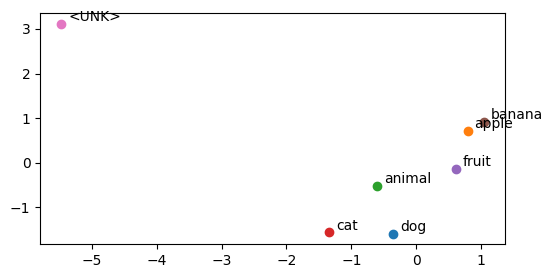

In [107]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs):
    x,y = get_embed(word)
    plt.scatter(x,y)
    plt.annotate(word, xy = (x,y), xytext = (5,2), textcoords='offset points')
plt.show()

## 6. Cosine Similarity

In [108]:
banana = get_embed('banana')
banana

(1.0454379320144653, 0.9094761610031128)

In [109]:
fruit = get_embed('fruit')
fruit

(0.6133660674095154, -0.14350289106369019)

In [110]:
np.array(banana) @ np.array(fruit)

0.510723694622996

In [111]:
cat = get_embed('cat')

In [112]:
np.array(banana) @ np.array(cat)

-2.827752410042052

In [113]:
unk = get_embed('<UNK>')

In [114]:
np.array(banana) @ np.array(unk)

-2.884072177894012